In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import itertools
from collections import Counter 
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder

In [5]:
df = pd.read_csv("Disease_Dataset.csv")
print(df.shape)
print(df.columns)
print(df['diseases'].value_counts().head())

(246945, 378)
Index(['diseases', 'anxiety and nervousness', 'depression',
       'shortness of breath', 'depressive or psychotic symptoms',
       'sharp chest pain', 'dizziness', 'insomnia',
       'abnormal involuntary movements', 'chest tightness',
       ...
       'stuttering or stammering', 'problems with orgasm', 'nose deformity',
       'lump over jaw', 'sore in nose', 'hip weakness', 'back swelling',
       'ankle stiffness or tightness', 'ankle weakness', 'neck weakness'],
      dtype='object', length=378)
diseases
cystitis                          1219
vulvodynia                        1218
nose disorder                     1218
complex regional pain syndrome    1217
spondylosis                       1216
Name: count, dtype: int64


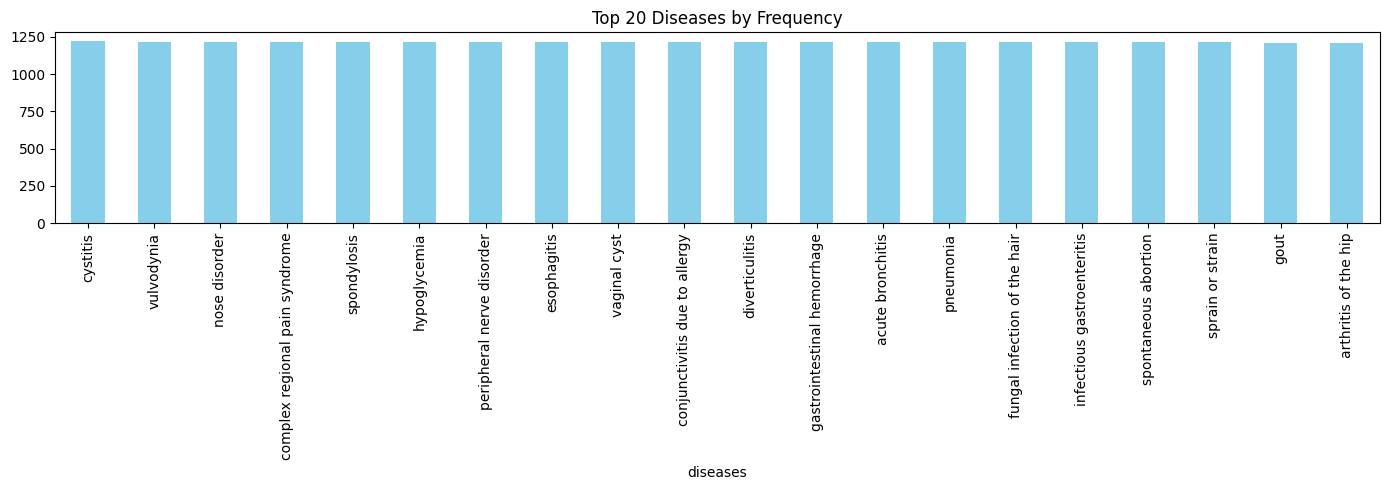

In [6]:
plt.figure(figsize=(14, 5))
df['diseases'].value_counts().head(20).plot(kind='bar', color='skyblue')
plt.title("Top 20 Diseases by Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:


df = pd.read_csv("Disease_Dataset.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:10])
print("Null values:\n", df.isnull().sum().sort_values(ascending=False).head())

# Encoding disease labels
le = LabelEncoder()
df['disease_encoded'] = le.fit_transform(df['diseases'])

label_counts = df['disease_encoded'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df = df[df['disease_encoded'].isin(valid_labels)]

# Defining features and target
X = df.drop(['diseases', 'disease_encoded'], axis=1)
y = df['disease_encoded']

# Spliting the data (stratify is now safe)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Normalizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

import joblib
joblib.dump(le, 'label_encoder.pkl')


🧪 Shape: (246945, 378)
📋 Columns: ['diseases', 'anxiety and nervousness', 'depression', 'shortness of breath', 'depressive or psychotic symptoms', 'sharp chest pain', 'dizziness', 'insomnia', 'abnormal involuntary movements', 'chest tightness']
🧼 Null values:
 diseases                      0
stiffness all over            0
infertility                   0
painful menstruation          0
unpredictable menstruation    0
dtype: int64


['label_encoder.pkl']

In [ ]:
le = LabelEncoder()
df['diseases_encoded'] = le.fit_transform(df['diseases'])

In [ ]:
# Removing classes with ≤ 1 sample
value_counts = df['diseases_encoded'].value_counts()
valid_classes = value_counts[value_counts > 1].index
df_filtered = df[df['diseases_encoded'].isin(valid_classes)].copy()

# Separating features and target
X = df_filtered.drop(['diseases', 'diseases_encoded'], axis=1)
y = df_filtered['diseases_encoded']

# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Filtered dataset shape: {df_filtered.shape}")
print(f"Unique classes after filtering: {y.nunique()}")


✅ Filtered dataset shape: (246926, 379)
🧪 Unique classes after filtering: 754


In [ ]:
# Remove rare classes (appearing only once)
disease_counts = df['diseases'].value_counts()
df_filtered = df[df['diseases'].isin(disease_counts[disease_counts > 1].index)]

# Split features and target
X = df_filtered.drop("diseases", axis=1)
y = df_filtered["diseases"]

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# Initialize XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    verbosity=1
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Step 8: Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Classification report
print("Classification Report:\n", classification_report(
    y_test, y_pred_xgb,
    labels=range(len(le.classes_)),
    target_names=le.classes_,
    zero_division=0
))


⚡ XGBoost Accuracy: 0.05133480204756042
📋 Classification Report:
                                                           precision    recall  f1-score   support

                               abdominal aortic aneurysm       0.00      0.00      0.00        34
                                        abdominal hernia       0.00      0.00      0.00       102
                                         abscess of nose       0.00      0.00      0.00        73
                                     abscess of the lung       0.00      0.00      0.00         5
                                  abscess of the pharynx       0.00      0.00      0.00        85
                                    acanthosis nigricans       0.00      0.00      0.00         7
                                               acariasis       0.00      0.00      0.00         9
                                               achalasia       0.00      0.00      0.00        21
                                                   

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
svm_model = LinearSVC(class_weight='balanced', max_iter=5000)
svm_model.fit(X_train, y_train_enc)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test_enc, y_pred_svm))

💠 SVM Accuracy: 0.8622918421564181


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
log_model = LogisticRegression(max_iter=1000, n_jobs=-1)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
joblib.dump(log_model, 'logistic_model.pkl')

📌 Logistic Regression Accuracy: 0.8679615110477548
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        34
           1       0.94      0.99      0.97       102
           2       0.94      0.88      0.91        73
           3       1.00      0.80      0.89         5
           4       0.86      0.94      0.90        85
           5       0.78      1.00      0.88         7
           6       0.80      0.89      0.84         9
           7       0.64      0.76      0.70        21
           8       0.67      0.87      0.76       124
           9       0.94      0.74      0.83       227
          10       0.94      0.92      0.93       301
          11       0.91      0.73      0.81       303
          12       0.72      0.74      0.73       227
          13       0.50      1.00      0.67         2
          14       0.56      0.37      0.44        52
          15       0.96      0.96      0.96       227
    

['logistic_model.pkl']

In [ ]:
user_input = [0]*377
user_input[25] = 1
user_input[34] = 1
user_input[102] = 1

predicted_disease = log_model.predict([user_input])[0]
real_disease_name = le.inverse_transform([predicted_disease])[0]
print("Predicted Disease:", real_disease_name)


Predicted Disease: abdominal hernia


In [ ]:
import joblib
joblib.dump(log_model, 'logistic_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [ ]:
df = pd.read_csv("Disease_Dataset.csv")
symptom_columns = [col for col in df.columns if col != 'diseases']
capitalized_symptoms = [symptom.strip().capitalize() for symptom in symptom_columns]
with open("symptom_list.txt", "w") as f:
    for symptom in capitalized_symptoms:
        f.write(symptom + "\n")

✅ Saved 377 capitalized symptoms to symptom_list.txt


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_encoded)
joblib.dump(model, "logistic_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [ ]:
le = LabelEncoder()
df['disease_encoded'] = le.fit_transform(df['diseases']) 
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [23]:
print(label_encoder.classes_)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 24

In [ ]:
X = df.drop('disease_encoded', axis=1)
y = df['disease_encoded']
joblib.dump(model, "logistic_model.pkl")

['logistic_model.pkl']

In [ ]:
idx = 225
print(le.inverse_transform([idx]))

['ependymoma']
